# Problem 2 - Answers

## Imports and Setup

Matplotlib inline plotting will set the matplotlib backend to ensure that the plots will not appear in a separate window, but rather in the notebook itself. 
Of course plots can always be saved to a separate file using the `savefig` command or shown in a separate window by changing the [matplotlib backend](https://matplotlib.org/3.1.1/tutorials/introductory/usage.html#backends) (advanced!).
                                                                                                                                                                                                                                                                                   
These imported packages are used throughout the Jupyter Notebook.                                                                                                                                                      
The [matplotlib](https://matplotlib.org/) package is used for plotting, while [NumPy](https://numpy.org/) is used for underlying numerical calculations.
[SciPy](https://www.scipy.org/) provides multiple advanced routines, such as routines for solving differential equations which are used in this notebook.
The electrostatics module defines simple routines to calculated electric fields for different arrangements of charges.

In [1]:
%matplotlib inline

from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

from electrostatics import E_dir

mpl.rc("figure", figsize=(10, 10))
mpl.rc("font", size=16)

## Geometry Functions

These functions are designed to carry out essential geometric manipulations with the overall goal of being able to generate multiple seed coordinates regularly spaced around a given coordinate (like a charge's position).

In [2]:
def get_rot_matrix(rad):
    """Return the 2D rotation matrix given an angle (in radians)."""
    return np.array([[np.cos(rad), np.sin(rad)], [-np.sin(rad), np.cos(rad)]])


def generate_circular_coords(centre_x, centre_y, radius, offset_deg, samples):
    """Generate coordinates along a circle.
    
    Args:
        centre_x (float): x-coordinate of the circle.
        centre_y (float): y-coordinate of the circle.
        radius (float): Distance of the generated coordinates from the centre.
        offset_deg (float): Degrees to offset the generated samples by.
        samples (int): Number of samples to generate.
        
    Returns:
        numpy.ndarray: (2, samples) array containing the x, y coordinates of the samples.
    
    """
    angles = np.radians(
        np.linspace(offset_deg, 360 + offset_deg, samples, endpoint=False)
    )
    rot_matrices = get_rot_matrix(angles)
    coords = []
    start_vec = np.array([[0], [radius]], dtype=np.float64)
    for i in range(samples):
        rot_matrix = rot_matrices[..., i]
        coords.append(rot_matrix.dot(start_vec))
    return np.hstack(coords) + np.array([[centre_x], [centre_y]], dtype=np.float64)

## Calculating the Field Lines

These functions actually carry out the field line calculations, by integrating the differential equations governing the direction of the field lines until certain criteria are met. 

Besides the usual caveats regarding the nature of numerical integration, the most important shortcoming of this algorithm is its failure to handle field lines which extend infinitely. On its own, this is no problem, since the integration can simply be terminated at some arbitrary distance (which is the way it is handled here). However, if one relies on the termination of field lines at other charges to satisfy the proportionality between the field strength and the number of field lines, then 'losing' a field line like this is only acceptable if &mdash; by some symmetry &mdash; the corresponding field line is recovered at the other charge. 

In [3]:
def exp_value_format(values, sig=1):
    """Exponential string formatting of input values."""
    return str(tuple(map(lambda s: format(s, f"0.{sig - 1}e"), values))).replace(
        "'", ""
    )


def field_line_func(t, pos, q, r, check_positions, charge_radius=0.01):
    """For use with `solve_ivp`. Returns E-field direction.
    
    Args:
        pos (iterable): x, y position.
        q (numpy.ndarray): (N,) array of point charge charges.
        r (numpy.ndarray): (2, N) array of point charge positions.
        check_positions (numpy.ndarray): (2, N - 1) array containing all point
            charge positions but the point charge at which the field line
            originated. This is done to avoid early termination of the 
            field line.
        charge_radius (float): The distance below which a field line is 
            deemed to be 'in contact' with a charge, and the integration is 
            meant to be terminated.
    
    Returns:
        (2,) numpy.ndarray: Electric field vector at `pos`. If `pos` is closer 
        than `charge_radius` to any of the positions in `check_positions`, 
        [0, 0] is returned to signal the end of the integration.
    
    """
    xy = np.array(pos).reshape(2, 1)
    distances = np.linalg.norm(check_positions - xy, axis=0)

    # Terminate the field line when a charge is reached.
    if np.any(distances < charge_radius):
        return np.array([0, 0])
    return E_dir(*pos, q, r)


def get_field_line(
    x,
    y,
    positions,
    charges,
    charge_radius=0.01,
    resolution=100,
    ignore_charge=None,
    integration_direction=1.0,
    verbose=False,
):
    """Get coordinates of a field line.
    
    The positions that are sampled along the field line are calculated by incrementally
    integrating along the field line until the area of interest is exceeded or another 
    charge is encountered.
    
    Args:
        x (float): Starting x coordinate of the field line.
        y (float): Starting y coordinate of the field line.
        positions (numpy.ndarray): (2, N) array of point charge positions.
        charges (numpy.ndarray): (N,) array of point charge charges.
        charges_radius (float, optional): Radius assigned to the point charges
            to detect field line termination.
        resolution (int): Number of points to sample per unit length.
        ignore_charge (int): Charge to ignore when checking for field line termination. If
            a field line is calculated which originates from a charge, this charge's index 
            should be given to avoid early termination.
        integration_direction (float): A +ve number indicates that integration should occur from
            +ve charges to -ve charges, and vice versa. When integrating field lines starting 
            from a charge, simply supply the charge value here to construct the field line.
        verbose (bool): If True, print out information regarding early field line termination.
    
    Returns:
        (2, K) numpy.ndarray: Array containing the points along the field line
        with the x-coordinates in the first row and the y-coordinates in the second.
        
    """
    scale = np.linalg.norm(np.ptp(positions, axis=1))

    check_positions = positions
    if ignore_charge is not None:
        check_positions = np.delete(check_positions, ignore_charge, axis=1)

    tmin = 0
    # tmax will always be updated to reflect the minimum distance to a charge.
    tmax = np.sign(integration_direction) * np.min(
        np.linalg.norm(check_positions - np.array([[x], [y]]), axis=0)
    )

    startx = x
    starty = y
    points = np.zeros((2, 0), dtype=np.float64)

    initial_pos = (startx, starty)

    # Integrate along the field line until a charge is encountered.
    counter = 0
    while True:
        sol = solve_ivp(
            partial(
                field_line_func,
                q=charges,
                r=positions,
                check_positions=check_positions,
                charge_radius=charge_radius,
            ),
            [tmin, tmax],
            [startx, starty],
            t_eval=np.linspace(tmin, tmax, int(max((resolution * (abs(tmax) - tmin), 2)))),
            rtol=1e-7,
        )
        points = np.hstack((points, sol.y[:, min((counter, 1)) :]))

        # Check for termination of the field line.
        # If it is in contact with a charge.
        distances = np.linalg.norm(check_positions - sol.y[:, -1:], axis=0)
        close_charges = distances < charge_radius
        if any(close_charges):
            assert (
                sum(close_charges) == 1
            ), "The field line should only terminate at a single charge (if any)."
            break

        tmax = np.sign(integration_direction) * np.min(distances)
        if abs(tmax) > 1e4 * scale:
            msg = (
                "Terminating integration, as the field line is too long! "
                f"Final position: {exp_value_format(sol.y[:, -1].flatten())}."
            )
            if verbose:
                print(msg)
            return points[:, : int(1e5)][:, :: int(np.sign(integration_direction))]

        startx, starty = sol.y[:, -1]
        counter += 1

    # Multiple points in viccinity of the same charge (where the field line termintaes)
    # will be removed to yield the final list of points.
    charges_close_points = list(
        filter(
            any,
            (
                np.linalg.norm(points - charge_pos.reshape(2, 1), axis=0)
                < charge_radius
                for charge_pos in check_positions.T
            ),
        )
    )

    assert (
        len(charges_close_points) <= 1
    ), "The field line should only terminate at a single charge (if any)."

    if len(charges_close_points) == 1:
        close_points = charges_close_points[0]
        first_close_point = np.where(close_points)[0][0]
        assert np.all(
            close_points[first_close_point:]
        ), "All points after the first close point should also be close."
        return points[:, : first_close_point + 1][
            :, :: int(np.sign(integration_direction))
        ]

    return points[:, :: int(np.sign(integration_direction))]


def plot_field_line(
    x,
    y,
    positions,
    charges,
    ignore_charge=None,
    integration_direction=1.0,
    ax=None,
    color="C0",
    label="field line",
    arrow_size=23,
    linestyle="-",
):
    """Calculate and plot a field line onto a given axis.
    
    Args:
        x (float): Starting x coordinate of the field line.
        y (float): Starting y coordinate of the field line.
        positions (numpy.ndarray): (2, N) array of point charge positions.
        charges (numpy.ndarray): (N,) array of point charge charges.        
        ignore_charge (int): Charge to ignore when checking for field line termination. If
            a field line is calculated which originates from a charge, this charge's index 
            should be given to avoid early termination.
        integration_direction (float): A +ve number indicates that integration should occur from
            +ve charges to -ve charges, and vice versa. When integrating field lines starting 
            from a charge, simply supply the charge value here to construct the field line.
        ax (matplotlib axis): Axis onto which to plot the field line.
        color (str or tuple): Color of the field line and associated arrow.
        label (str or None): Field line label.
        arrow_size (int): Size of the arrow.
        linestyle (str): Filed line plotting linestyle.

    """
    field_line = get_field_line(
        x,
        y,
        positions,
        charges,
        ignore_charge=ignore_charge,
        integration_direction=integration_direction,
    )
    line = ax.plot(*field_line, label=label, color=color, linestyle=linestyle)[0]

    index = int(field_line.shape[1] / 2)
    # Place the arrow on a 'line' drawn approximately perpendicular to the line at the target (index) point.
    coords = field_line[:, index - 1 : index + 2]
    mean_vec = ((coords[:, 1] - coords[:, 0]) + (coords[:, 2] - coords[:, 1])) / 2
    mean_sep = np.linalg.norm(mean_vec)

    xytext = coords[:, 1] - mean_sep * mean_vec / 2
    xy = coords[:, 1] + mean_sep * mean_vec / 2

    # Only add the text if it is within the axis bounds.
    if not (
        max((xytext[0], xy[0])) > ax.get_xlim()[1]
        or min((xytext[0], xy[0])) < ax.get_xlim()[0]
        or max((xytext[1], xy[1])) > ax.get_ylim()[1]
        or min((xytext[1], xy[1])) < ax.get_ylim()[0]
    ):
        line.axes.annotate(
            "",
            xytext=xytext,
            xy=xy,
            arrowprops=dict(arrowstyle="fancy", color=line.get_color()),
            size=arrow_size,
        )

### A Simple Configuration

This simple case will depict field lines from two charges at positions (-1, 0) and (1, 0) with charges 1 and -1 respectively.

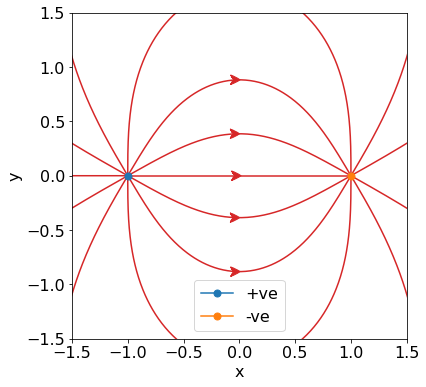

In [4]:
charges = np.array([1, -1])
positions = np.array([(-1, 0), (1, 0)]).T

fig,ax = plt.subplots(figsize=(6,6))

# Set the axis limits beforehand, so that the plotting code knows
# which text labels to ignore (bug in Jupyter which does not clip
# text).

xm, ym = 1.5, 1.5
ax.set_xlim(-xm, xm)
ax.set_ylim(-ym, ym)
ax.set_xlabel("x")
ax.set_ylabel("y")

#plt.gca().set_xlim(-xm, xm)
#plt.gca().set_ylim(-ym, ym)

for (i, (charge_pos, charge, color, linestyle)) in enumerate(
    zip(positions.T, charges, ["C3"], ["-"])
):
    start_coords = generate_circular_coords(*charge_pos, 0.02, 0, 12)
    for coords in start_coords.T:
        plot_field_line(
            *coords,
            positions,
            charges,
            ignore_charge=i,
            integration_direction=charges[i],
            ax=plt.gca(),
            color=color,
            linestyle=linestyle,
            label=None
        )

plt.plot(*positions[:, 0], marker="o", label="+ve", ms=7)
plt.plot(*positions[:, 1], marker="o", label="-ve", ms=7)

_ = plt.legend(loc="best")

### Expanding upon the Simple Configuration

This example is similar to the one above, in that all the charges have magnitude 1. The top dipole is a mirrored version of the previous two charges.
The charges in this example are positioned at (1, 1), (1, -1), (-1, -1), and (-1, 1) with charges 1, -1, 1, and -1 respectively.

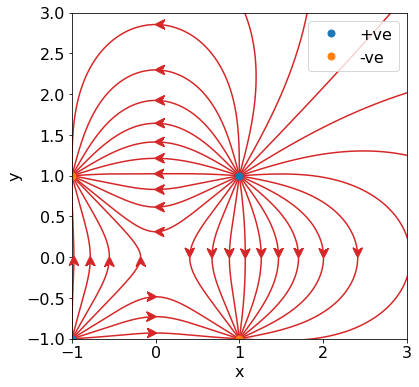

In [5]:
charges = np.array([1, -1, 1, -1])
positions = np.array([(1, 1), (1, -1), (-1, -1), (-1, 1)]).T

fig,ax = plt.subplots(figsize=(6,6))

xm, ym = 3, 3
ax.set_xlim(-1, xm)
ax.set_ylim(-1, ym)
ax.set_xlabel("x")
ax.set_ylabel("y")

for i, charge_pos, charge, color, linestyle in zip(
    list(range(len(charges)))[::2],
    positions.T[::2],
    charges[::2],
    ["C3", "C3"],
    ["-", "-"],
):
    start_coords = generate_circular_coords(
        *charge_pos, 0.02, 0, int(round(25 * abs(charge)))
    )
    for j, coords in enumerate(start_coords.T):
        plot_field_line(
            *coords,
            positions,
            charges,
            ignore_charge=i,
            integration_direction=charges[i],
            ax=plt.gca(),
            color=color,
            linestyle=linestyle,
            label=None
        )

plt.plot(*positions[:, 0::2], marker="o", label="+ve", ms=7, linestyle="", color="C0")
plt.plot(*positions[:, 1::2], marker="o", label="-ve", ms=7, linestyle="", color="C1")

_ = plt.legend(loc="best")

### A More Complicated Example

In this example, 4 charges are placed at the vertices of a square, ie. at (1, 1), (1, -1), (-1, -1), and (-1, 1). 
These charges are all of magnitude 1.

Another charge is placed in the centre of the square at (0, 0), with charge -2.
This introduces the challenge of satisfying the proportionality between the number of field lines and the electric field magnitude.
Here, this is solved simply by only plotting field lines connected to the outer 4 charges.
The inner charge is merely a destination for field lines to terminate at (speaking from the viewpoint of the integration).

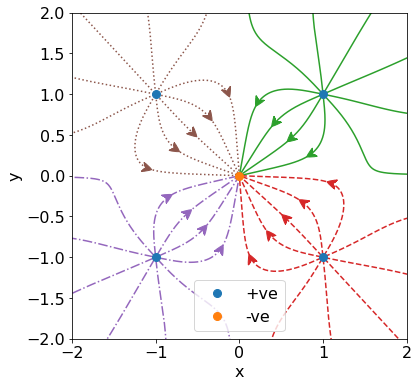

In [6]:
import warnings

warnings.filterwarnings("ignore", "divide by zero")
warnings.filterwarnings("ignore", "invalid value")

charges = np.array([1, 1, 1, 1, -2])
positions = np.array([(1, 1), (1, -1), (-1, -1), (-1, 1), (0, 0)]).T

fig,ax = plt.subplots(figsize=(6,6))

xm, ym = 2, 2
ax.set_xlim(-xm, xm)
ax.set_ylim(-ym, ym)
ax.set_xlabel("x")
ax.set_ylabel("y")

for (i, (charge_pos, charge, color, linestyle)) in enumerate(
    zip(positions.T[:4], charges[:4], ["C2", "C3", "C4", "C5"], ["-", "--", "-.", ":"])
):
    start_coords = generate_circular_coords(
        *charge_pos, 0.02, 30, int(round(10 * abs(charge)))
    )
    for j, coords in enumerate(start_coords.T):
        plot_field_line(
            *coords,
            positions,
            charges,
            ignore_charge=i,
            integration_direction=charges[i],
            ax=plt.gca(),
            color=color,
            linestyle=linestyle,
            label=None
        )

plt.plot(*positions[:, 0:4], marker="o", label="+ve", ms=8, linestyle="", color="C0")
plt.plot(*positions[:, 4:], marker="o", label="-ve", ms=8, linestyle="", color="C1")

_ = plt.legend(loc="best")